# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision import transforms
import torch
from torch import nn
from torchsummary import summary
import torch.nn.functional as func
from torch.autograd import Variable

In [5]:
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

./tiny-imagenet-200.zip


In [13]:
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])

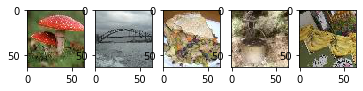

In [126]:
plt.figure(figsize=[12,4])
for i in range(5):
    plt.subplot(2,10,i+1)
    plt.imshow(np.rollaxis(train_dataset[i][0].numpy(), 0, 3))

In [92]:
import time
from tqdm import tqdm_notebook
from IPython.display import clear_output

def compute_loss(model, X_batch, y_batch):
    logits = model(X_batch)
    return func.cross_entropy(logits, y_batch).mean()


num_epochs=100
batch_size=50
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)

train_loss = []
val_accuracy = []

In [ ]:
for epoch in range(num_epochs):
    print (num_epochs)
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm_notebook(train_batch_gen):
        # train on batch
        loss = compute_loss(model, X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())  
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(X_batch)
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean( (y_batch == y_pred).numpy() ))

    clear_output(wait=True)
    print (num_epochs)
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

In [127]:
model = nn.Sequential()

model.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3))
model.add_module("bn1", nn.BatchNorm2d(64))
model.add_module("conv1_relu", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(3))

model.add_module("conv2", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3))
model.add_module("bn2", nn.BatchNorm2d(128))
model.add_module("conv2_relu", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(2))

model.add_module('flatten', nn.Flatten())
model.add_module('dense1_logits', nn.Linear(10368, 200)) # logits for 200 classes
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]           1,792
       BatchNorm2d-2           [-1, 64, 62, 62]             128
              ReLU-3           [-1, 64, 62, 62]               0
         MaxPool2d-4           [-1, 64, 20, 20]               0
            Conv2d-5          [-1, 128, 18, 18]          73,856
       BatchNorm2d-6          [-1, 128, 18, 18]             256
              ReLU-7          [-1, 128, 18, 18]               0
         MaxPool2d-8            [-1, 128, 9, 9]               0
           Flatten-9                [-1, 10368]               0
           Linear-10                  [-1, 200]       2,073,800
Total params: 2,149,832
Trainable params: 2,149,832
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 6.94
Params size (MB): 8.20
Estimat

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [ ]:
test_accuracy = .... # YOUR CODE

In [ ]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]